# WaveNet音乐生成案例

## WaveNet简介

WaveNet属于生成模型的范畴，能够直接对原始音频信号建模，常用于文本合成语音（TTS，Text to Speech）、音频生成及音素识别任务。WaveNet网络架构融合了扩张卷积（或称空洞卷积，dilated convolution)、残差结构、门控激活单元等多种经典结构。由于直接模拟音频信号的原始波形，WaveNet可以模拟任何类型的音频。在语音合成任务上，相比于当时最好的文本合成语音系统具有更加更自然的听觉效果，将机器合成语音与人类真实语音之间的差距缩小了50%以上。

### Wavenet基本原理

Wavenet的作者受PixelRNN和PixelCNN模型的启发，将用于二维PixelNets修改为适用于一维时序信号（音频信号）的WaveNet。具体地，WaveNet将当前时刻音频信号（又称为当前时刻的音频样本）的联合概率分布分解为过去多个时刻音频信号的条件概率分布的乘积：
$$
p(x)=\prod_{t=1}^Tp(x_t|x_1, x_2, ...,x_{t-1})
$$
可以看出，每个时刻的音频样本都只依赖于过去时间的所有样本。

> 1. 如果系统当前时刻的输出信号只依赖过去时刻的信号，而与未来时刻的信号无关，则称这个系统具有*因果性*。
> 2. 通过变量x过去各个时刻的自身数据来预测自身当前时刻的输出，称这类模型为**自回归模型（AR，Autoregressive model)**。

电子设备中存储的原始音频信号虽然是经过采样量化处理得到的数字信号，但相邻两个时刻的样本间隔太小，导致每秒包含16,000个或更多样本。要建立一个每个样本的预测都受到之前所有样本的影响（从统计学上讲，每个预测分布都取决于之前的所有观测结果）的完全自回归的模型是十分困难的。

> 笔者述：换句话说，网络的一个输出样本需要与过去时刻的大量样本建立联系，意味着网络在时域的感知范围（即感受野）要非常大，WaveNet是基于一维卷积操作的神经网络，仅通过堆叠网络深度来拓展感受野，效率是十分低下的。

为了快速提高网络的感受野，WaveNet使用了一维扩张卷积。

#### 扩张卷积

<div align=center>
    <img src="./imgs/img3.jpg" alt="因果扩张卷积" title="一维因果扩张卷积" style="zoom:67%;" />  
</div>




扩张卷积是WaveNet的核心操作。一维扩张卷积在普通一维卷积的基础上引入了扩张系数dilation，其含义为卷积层将选取相隔dilation-1个的输入节点做求权处理，由于卷积核的大小并没有发生改变，扩张卷积在不引入额外计算量的前提下有效提高了网络的感受野。如上图所示，第3层的扩张系数为4，则卷积核每隔3个节点选取输入节点。通过堆叠扩张系数逐渐增加的扩张卷积，网络的感受野大小呈指数增长。

#### 门控激活单元

<div align=center>
  <img src="./imgs/img4.png" alt="门控激活单元" title="门控激活单元" style="zoom:50%;" />
</div>




WaveNet架构采用了和LSTM相同的激活函数，门控激活单元（图红色方框内）。相较于其他激活函数，门控激活单元在处理音频信号上能够传递更加平滑的梯度信息，具有更加出色的性能。在扩张卷积之后，操作流在分别经过tanh函数和sigmoid函数的处理后相乘，得到激活值。

#### 残差单元

<div align=center>
    <img src="./imgs/img5.png" alt="残差结构" style="zoom:50%;" />
</div>


CNN网络无法像RNN那样通过循环操作传递长距离历史信息，WaveNet在通过堆叠深度进一步提升网络的感受野的同时，采用了残差结构和跳跃链接加快梯度的传播。如图所示的残差单元，除了输入与输出的残差链接，残差块的输出通过跳跃链接与网络输出相连。

### Wavenet网络结构

<div align=center>
    <img src="./imgs/img6.png" alt="网络结构" style="zoom:50%;" />
</div>


WaveNet的整体结构如图所示，其基本组成单元为残差单元。残差单元由扩张卷积、门控激活函数及全链接层组成（由卷积核为1的卷积层实现）。每个残差单元的输出通过跳跃链接与网络输出聚合后作为当前时刻样本的预测输出。

## 基于MindSpore的WaveNet音乐生成

### 数据预处理

一般情况下，原始音频存储为16位整数值序列，即音频信号共有65536种量化结果。WaveNet将样本点的预测视为量化区间的分类问题，这意味着最终的SoftMax层将要输出65536个类别的概率。为了降低网络参数量及预测难度，我们通常使用 $\mu$ 率压扩变换将原始音频信号量化到256个值：
$$
f(x_t)=sign(x_t)\frac{ln(1+\mu|x_t|)}{ln(1+\mu)}, -1<x_t<1,\mu=255.
$$
注意，对这种非线性量化方式重建后的音频信号与原始音频信号十分相似。

### 数据集构建

<div align=center>
    <img src="./imgs/img2.gif" alt="动画" style="zoom:70%;" />
</div>

如图所示，WaveNet**在推理时**，我们根据前n个时刻的样本预测当前时刻的样本值（**即网络的输入序列长度n为网络的感受野**），然后我们将当前时刻的预测值也作为n个输入中的一个输入网络中，预测下一时刻的样本点。

而**在训练时**，我们只训练网络根据n个输入预测第$n+1$个值。为了提高效率，我们通常设定网络一次性预测长度为$o$的输出，根据一个预测样本对应网络感受野大小的样本的输入，网络的输入长度应为$n+o-1$。据此我们构建数据集：

In [1]:
# 安装音频处理所需要的依赖包，通过librosa对音频进行导入, 通过soundfile对音频导出，利用nnmnkwii提供的算法接口对音频进行μ率扩缩
!pip install librosa
!pip install soundfile
!pip install nnmnkwii

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple


我们首先调用```generate_dataset```方法将原始音频文件进行μ率压缩及量化得到用于网络训练和推理的数据集。

In [2]:
import mindspore as ms
import mindspore.dataset as ds
import numpy as np
from pathlib import Path
from datetime import datetime

import librosa
from nnmnkwii import preprocessing as pre
import soundfile as sf


def generate_dataset(file_location, out_file, sampling_rate=16000, mono=True):
    audio_files = Path(file_location).glob("*")
    processed_files = []
    for idx, file_wav in enumerate(audio_files):
        audio, _ = librosa.load(str(file_wav), sr=sampling_rate, mono=mono)
        if idx == 0:
            # 分割数据集中的第一个音频，将其十分之一长度作为预测音乐的开头样本（独立同分布）
            pred_head = audio[:len(audio) // 10]
            audio = audio[len(audio) // 10:]
            sf.write("pred_head.wav", pred_head, 16000, subtype='PCM_24')
            sf.write("train_audio.wav", audio, 16000, subtype='PCM_24')
            np.savez("pred_head.npz", pre.mulaw_quantize(pred_head, 256))
        
        wav_quantized = pre.mulaw_quantize(audio, 256)
        print("generated from audio file: " + str(file_wav.name))
        processed_files.append(wav_quantized) 
    np.savez(out_file, *processed_files)
    
    
class WaveDataset:
    def __init__(self, 
                 dataset_file, 
                 receptive_feild, 
                 output_length,
                 classes=256,
                 sampling_rate=16000,
                 mono=True,
                 wave_location=None):

        self.dataset_file = dataset_file
        self.receptive_feild = receptive_feild
        self.output_length = output_length
        self.item_length = receptive_feild + output_length
        self.classes = classes

        if not Path(dataset_file).exists():
            print(f"{dataset_file} not found, generating dataset file ...")
            generate_dataset(wave_location, dataset_file, sampling_rate, mono)
            print(f"datset file {dataset_file} generated.")

        self.data = []
        dataset = np.load(self.dataset_file, mmap_mode="r")
        print(f"dataset file {self.dataset_file} loaded")
        for i in range(len(dataset)):
            self.data.append(dataset["arr_" + str(i)])
        self.index_seg = []
        self.collect_segment_index()


    
    def collect_segment_index(self):
        for i, audio in enumerate(self.data):
            len_audio = len(audio)
            N_seg = (len_audio - self.item_length) // self.output_length
            for j in range(N_seg):
                pos_start = j * self.output_length
                pos_end   = pos_start + self.item_length
                if pos_end < len_audio:
                    self.index_seg.append((i, pos_start, pos_end))
            self.index_seg.append((i, len_audio - self.item_length, len_audio))

    def __len__(self):
        return len(self.index_seg)

    def get_onehot(self, slice):
        onehot_ = np.eye(self.classes)[slice]
        return onehot_.transpose()
 
    def __getitem__(self, index):
        num_audio, pos_start, pos_end = self.index_seg[index]
        data_slice = self.data[num_audio][pos_start: pos_end]
        onehot = self.get_onehot(data_slice[: -1])
        target = data_slice[-self.item_length + 1:]
        return onehot.astype(np.float32), target.astype(np.int32)

    
def create_dataset(dataset_file, receptive_feild, output_length, batch_size, classes=256, sampling_rate=16000, mono=True, wave_location=None):     
    dataset = ds.GeneratorDataset(WaveDataset(dataset_file=dataset_file,                                                
                                              receptive_feild=receptive_feild,                                                
                                              output_length=output_length,                                                
                                              classes=classes,                                                
                                              sampling_rate=sampling_rate,                                                
                                              mono=mono,                                                
                                              wave_location=wave_location),                                    
                                  ["inputs", "targets"], num_parallel_workers=4, shuffle=True)     
    return dataset.batch(batch_size=batch_size)

### 创建网络

#### 残差单元

在残差单元的实际实现中，除了第一层的扩张卷积，数据流在门控激活单元每个分支的子激活函数之前也同样经过了扩张卷积的处理，一个残差单元中的所有扩张卷积具有相同的扩张系数，具体实现如下：

In [3]:
from mindspore import nn


class ResidualConv1dGLU(nn.Cell):
    """Residual dilated conv1d with gated activation units

    Args:
        residual_channels (int): Residual input / output channels
        gate_channels (int): Gated activation channels.
        kernel_size (int): Kernel size
        skip_out_channels (int): Skip connection channels. If None, it will set to the same as residual_channels.
        cin_channels (int): Local conditioning channels. If given negative value, local conditioning is disabled.
        gin_channels (int): Global conditioning channels. If given negative value, global conditioning is disabled.
        dropout (float): Dropout rate.
        padding (int): Padding for convolution layers. If None, padding value will be computed according to dilation
        and kernel_size.
        dilation (int): Dilation factor.

    """

    def __init__(self, residual_channels=None, gate_channels=None, kernel_size=None, skip_out_channels=None, bias=True,
                 dropout=1 - 0.95, dilation=1, cin_channels=-1, gin_channels=-1, padding=None, causal=True):
        super(ResidualConv1dGLU, self).__init__()
        self.dropout = dropout
        self.dropout_op = nn.Dropout(keep_prob=1. - self.dropout)
        # self.eval_split_op = P.Split(axis=-1, output_num=2)
        self.train_split_op = P.Split(axis=1, output_num=2)
        self.tanh = P.Tanh()
        self.sigmoid = P.Sigmoid()
        self.mul = P.Mul()
        self.add = P.Add()

        padding = (kernel_size - 1) * dilation
        # print(padding)
        self.conv = nn.Conv1d(residual_channels, gate_channels, kernel_size, pad_mode='pad',
                           padding=padding, dilation=dilation, has_bias=bias)
        gate_out_channels = gate_channels // 2
        self.conv1x1_out = nn.Conv1d(gate_out_channels, residual_channels, kernel_size=1, pad_mode='pad', padding=0, dilation=1, has_bias=True)
        self.conv1x1_skip = nn.Conv1d(gate_out_channels, skip_out_channels, kernel_size=1, pad_mode='pad', padding=0, dilation=1, has_bias=True)
        self.factor = math.sqrt(0.5)
        
    def construct(self, x):
        #            |----------------------------------------|     *residual*
        #            |                                        |
        #            |    |-- conv -- tanh --|                |
        # -> dilate -|----|                  * ----|-- 1x1 -- + -->	*input*
        #                 |-- conv -- sigm --|     |
        #                                         1x1
        #                                          |
        # ---------------------------------------> + ------------->	*skip*

        residual = x
        x = self.dropout_op(x)
        x = self.conv(x)
        # remove future time steps
        x = x[:, :, :residual.shape[-1]]
        split_op = self.train_split_op
        a, b = split_op(x)
        x = self.mul(self.tanh(a), self.sigmoid(b))

        s = self.conv1x1_skip(x)
        x = self.conv1x1_out(x)

        x = self.add(x, residual) * self.factor
        return x, s
        

#### WaveNet

在WaveNet的实际实现中，我们将整个网络划分为多个块，每个块由若干层残差单元组成。在每个块中，膨胀系数从1开始以2的倍数递增。如以4层残差单元为一个块，由2个块组成的WaveNet的膨胀系数应为[1, 2, 4, 8, 1, 2, 4, 8]。WaveNet的具体实现如下:

In [4]:
from mindspore.ops import operations as P
import math

class WaveNet(nn.Cell):
    def __init__(self, out_channels=256, layers=20, blocks=2,
                 residual_channels=512,
                 gate_channels=512,
                 skip_out_channels=512,
                 kernel_size=3, dropout=1 - 0.95):
        super().__init__()
        self.transpose_op = P.Transpose()
        self.softmax = P.Softmax(axis=1)
        self.reshape_op = P.Reshape()
        self.zeros_op = P.Zeros()
        self.ones_op = P.Ones()
        self.squeeze_op = P.Squeeze()
        self.expandim_op = P.ExpandDims()
        self.transpose_op = P.Transpose()
        self.tile_op = P.Tile()
        self.out_channels = out_channels
        self.fack_data = P.Zeros()
        print(f"network info: \n\tlayers: {layers}\n\tblocks:{blocks}")
        assert layers % blocks == 0
        
        self.layers_per_block = layers // blocks  # 24 / 4 = 6
        self.first_conv = nn.Conv1d(out_channels, residual_channels, kernel_size=1)
        conv_layers = []         
        for layer in range(layers):
            dilation = 2 ** (layer % self.layers_per_block)  # 1, 2, 4, 8, 16, 32
            conv = ResidualConv1dGLU(
                residual_channels, gate_channels,
                kernel_size=kernel_size,
                skip_out_channels=skip_out_channels,
                bias=True,
                dropout=dropout,
                dilation=dilation) 
            conv_layers.append(conv)   
        self.conv_layers = nn.CellList(conv_layers)   
        self.last_conv_layers = nn.CellList([   
            nn.ReLU(),        
            nn.Conv1d(skip_out_channels, skip_out_channels, kernel_size=1),        
            nn.ReLU(),         
            nn.Conv1d(skip_out_channels, out_channels, kernel_size=1)])
        self.factor = math.sqrt(1.0 / len(self.conv_layers))  # sqrt( 1 / 24)
        
        self.receptive_field = 1
        for _ in range(blocks):
            additional_scope = 2 
            for _ in range(self.layers_per_block):
                self.receptive_field += additional_scope
                additional_scope *= 2
        print("receptive filed: ", self.receptive_field)
        
    def construct(self, x, softmax=False):         
        
        B, _, T = x.shape
        x = self.first_conv(x)      
        skips = 0     
        for f in self.conv_layers:   
            x, hidden = f(x)  # x=[B, 128, 10240], hidden=[B, 128, 10240] 
            skips += hidden       
        skips *= self.factor     
        x = skips  # x=[B, 128, 10240]    
        for f in self.last_conv_layers:     
            x = f(x)  # x=[B, 2, 10240]    
        x = self.softmax(x) if softmax else x
        return x

### 模型训练

在模型训练中，一个完整的训练过程（step）需要实现以下三步：

1. **正向计算**：模型预测结果（logits），并与正确标签（label）求预测损失（loss）
2. **反向传播**：利用自动微分机制，自动求模型参数（parameters）对于loss的梯度（gradients
3. **参数优化**：将梯度更新到参数上

MindSpore使用函数式自动微分机制，因此针对上述步骤需要实现：  
1. 正向计算函数定义
2. 通过函数变换获得梯度计算函数 
3. 训练函数定义，执行正向计算、反向传播和参数优化  

In [5]:
from mindspore import ops
from mindspore.amp import all_finite
from pathlib import Path


def train_loop(model, dataset, loss_fn, optimizer, logger):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, logits), grads = grad_fn(data, label)
        if all_finite(grads):  
            loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    dataloader = dataset.create_tuple_iterator()
    
    loss_sum, iter_sum = 0., 0
    
    for batch, (data, label) in enumerate(dataloader):
        loss = train_step(data, label)
        logger.append(loss.asnumpy())
            
        if batch % 20 == 0:
            print("loss: {:>.3f}\t\t {:>4d}/{:>4d}".format(loss.asnumpy(), batch, size))


### 网络训练

实例化数据集、网络模型、优化器并开始训练。

In [6]:
# 训练模型
import numpy as np

ms.set_context(mode=ms.GRAPH_MODE)

dataset_file = "./dataset.npz"
wave_location = "./dataset/"

# 超参数设定
layers = 24
blocks = 4
residual_channels = 512
skip_channels = 512
gate_channels = 512
output_length = 64
classes = 256
epochs = 20
batch_size = 32
learning_rate = 0.001
model = WaveNet(out_channels=256, layers=layers, blocks=blocks, residual_channels=residual_channels, skip_out_channels=skip_channels, gate_channels=gate_channels)
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=learning_rate)
print("dataset loading ...")
dataset = create_dataset(dataset_file=dataset_file, wave_location=wave_location, batch_size=batch_size, classes=classes, output_length=output_length, receptive_feild=model.receptive_field, sampling_rate=16000, mono=True)
print("dataset loaded.\n\tdataset size: {:d}\n\tbatch size: {:d}".format(dataset.get_dataset_size(), dataset.get_batch_size()))

# 开始训练
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------------------------------------------------------------")
    loss_recoder = []
    train_loop(model, dataset, loss_fn, optimizer, loss_recoder)
    np.save("loss.npy", loss_recoder)
    ms.save_checkpoint(model, "./wavenet_{:d}.ckpt".format(t))

network info: 
	layers: 24
	blocks:4
receptive filed:  505
dataset loading ...
dataset file ./dataset.npz loaded
dataset loaded.
	dataset size: 4217
	batch size: 32
Epoch 1
---------------------------------------------------------------------------------------


[WARNING] DEVICE(23790,ffff904c9780,python):2022-11-10-14:30:26.265.495 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/conv_layers-CellList/23-ResidualConv1dGLU/dropout_op-Dropout/DropoutGenMask-op734] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(23790,ffff904c9780,python):2022-11-10-14:30:26.265.757 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/conv_layers-CellList/22-ResidualConv1dGLU/dropout_op-Dropout/DropoutGenMask-op735] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(23790,ffff904c9780,python):2022-11-10-14:30:26.265.903 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/conv_layers-CellList/21-ResidualConv1dGLU/dropout_op-Dropout/Dropout

loss: 5.545		    0/4217
loss: 5.127		   20/4217
loss: 5.352		   40/4217
loss: 4.907		   60/4217
loss: 4.723		   80/4217
loss: 4.418		  100/4217
loss: 4.196		  120/4217
loss: 4.028		  140/4217
loss: 3.891		  160/4217
loss: 3.751		  180/4217
loss: 3.662		  200/4217
loss: 3.766		  220/4217
loss: 3.652		  240/4217
loss: 3.498		  260/4217
loss: 3.604		  280/4217
loss: 3.656		  300/4217
loss: 3.427		  320/4217
loss: 3.288		  340/4217
loss: 3.388		  360/4217
loss: 3.370		  380/4217
loss: 3.483		  400/4217
loss: 3.350		  420/4217
loss: 3.363		  440/4217
loss: 3.350		  460/4217
loss: 3.275		  480/4217
loss: 3.510		  500/4217
loss: 3.328		  520/4217
loss: 3.381		  540/4217
loss: 3.267		  560/4217
loss: 3.473		  580/4217
loss: 3.411		  600/4217
loss: 3.316		  620/4217
loss: 3.433		  640/4217
loss: 3.348		  660/4217
loss: 3.236		  680/4217
loss: 3.154		  700/4217
loss: 3.193		  720/4217
loss: 3.409		  740/4217
loss: 3.447		  760/4217
loss: 3.242		  780/4217
loss: 3.294		  800/4217
loss: 3.258		  8

### 结果展示

运行下面代码，描绘损失与训练迭代关系图：从图中可以看到，标志着生成数据分布与真实数据分布的交叉熵损失随着迭代次数逐渐下降，网络能被正常优化

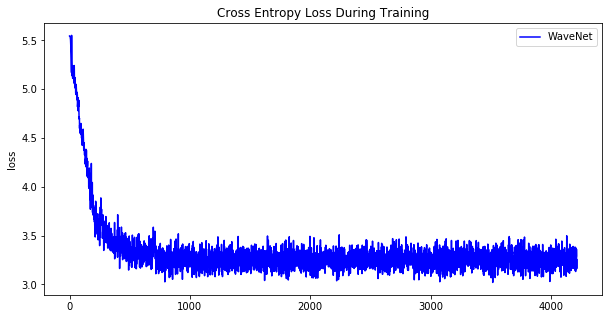

In [8]:
import matplotlib.pyplot as plt

loss = np.load("loss.npy")
plt.figure(figsize=(10, 5))
plt.title("Cross Entropy Loss During Training")
plt.plot(loss, label="WaveNet", color='blue')
plt.xlabel("")
plt.ylabel("loss")
plt.legend()
plt.show()

### 音乐生成

在这一部分中，我们加载训练好的WaveNet模型，并截取一小段与训练数据同分布的音频文件作为网络的预测的历史信息，并根据这些历史信息预测新的音频样本。

In [ ]:
import random
from tqdm import tqdm

def gen_music(model, gen_time_length, head_location, head_length=1024):
    '''
    gen_time_length: 要生成的时间长度，单位: 分钟
    head_location  ：预测头文件路径
    head_length    ：用于预测音频的头文件样本点个数，通常设置为网络的感受野
    '''
    
    head_file = np.load(head_location, mmap_mode="r")["arr_0"]
    random_start = random.randint(0, len(head_file) - head_length)
    head = head_file[random_start: random_start + head_length]
    total_length = int(gen_time_length * 16000 * 60)
    for _ in tqdm(range(total_length), ncols=60):
        pred = pred_one(model, head[-1024:]).asnumpy()
        head = np.append(head, pred)
    return head

def pred_one(model, x):
    onehot = np.eye(256)[x].transpose()
    pred = model(ms.Tensor(onehot).expand_dims(0).astype(ms.float32))
    pred_sample = pred[0, :, -1]
    return pred_sample.argmax()


model = WaveNet(out_channels=256, layers=24, blocks=4)
ms.load_checkpoint("wavenet_1.ckpt", model)
output = gen_music(model, gen_time_length=1/6, head_location="./pred_head.npz")  # 生成一个10s（1/6分钟）的片段
output = pre.inv_mulaw_quantize(output, 256)
sf.write("gen.wav", output, 16000, subtype='PCM_24')
print("generated")